In [1]:
from datetime import datetime

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import patsy

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

In [2]:
#  Abrindo o dataset
df = pd.read_excel(r"C:\Users\sabri\ipeadata[09-11-2023-07-57].xls")
df.head()

,Data,Sondagem Industrial - produção industrial - indústria de transformação - estoques - efetivo/planejado - índice - - - Confederação Nacional da Indústria - CNI12_INDTP12 -
0,2010.01,48.2
1,2010.02,48.6
2,2010.03,48.3
3,2010.04,48.5
4,2010.05,49.1


In [3]:
#  O formato de data utilizado não é o formato lido pelo pandas automaticamente.
#  Por isso são necessárias algumas adaptações para que 1 - a leitura ocorra corretamente e 2 - a data seja usada como índice

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y.%m') #  Função que converte os valores de data para a leitura pandas.
df = pd.read_excel(r"C:\Users\sabri\ipeadata[09-11-2023-07-57].xls", parse_dates=['Data'], index_col='Data',date_parser=dateparse) 
df.head() #  index_col = 'Data' -> séries temporais utilizando pandas têm os dados de data como índices

C:\Users\sabri\AppData\Local\Temp\ipykernel_14264\2987269046.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y.%m') #  Função que converte os valores de data para a leitura pandas.


,Sondagem Industrial - produção industrial - indústria de transformação - estoques - efetivo/planejado - índice - - - Confederação Nacional da Indústria - CNI12_INDTP12 -
Data,
2010-01-01,48.2
2010-02-01,48.6
2010-03-01,48.3
2010-04-01,48.5
2010-05-01,49.1


In [4]:
#  Renomeando a coluna para facilitar as demais etapas; ajustando os índices
df.columns = ['indice_efetivo_planejado']
df.sort_index(inplace=True)

In [5]:
#  Defino a minha timeseries ts:
ts = df['indice_efetivo_planejado']

In [6]:
#  Determinando média e variância móveis:
#  Obs: por intuição, faz sentido imaginar que os valores mais recentes são mais relevantes para estimações futuras em quase
#  todos os casos. 
rolmean = pd.Series(ts).rolling(window=12).mean()  #  média móvel no último ano 
rolstd = pd.Series(ts).rolling(window=12).std()  #  window é o último período que estou verificando

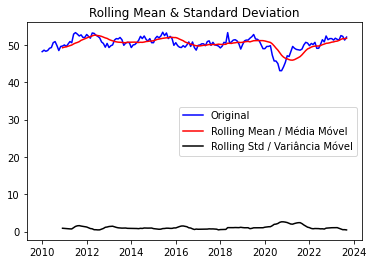

In [7]:
#  Plotando média móvel e variância móvel:
orig = plt.plot(ts, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean / Média Móvel')
std = plt.plot(rolstd, color='black', label = 'Rolling Std / Variância Móvel')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [8]:
#  Definindo função para a realização do teste de estacionariedade de Dickey-Fuller
#  Esse teste é o mais robusto para teste de estacionariedade
#  H0 - a série tem raiz unitária (não estacionária)
#  H1 - a série não tem raiz unitária (estacionária)
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [9]:
#  Teste de Estacionariedade da série temporal
#  Se a estatística de teste for menor que o valor crítico, rejeita-se H0
test_stationarity(ts)
#  -3,235073 > -3,470866 logo, não rejeito H0
#  Ou p-valor > 0,01 também não rejeito H0 para 99% de significância

Test Statistic                  -3.235073
p-value                          0.018042
#Lags Used                       0.000000
Number of Observations Used    164.000000
Critical Value (1%)             -3.470866
Critical Value (5%)             -2.879330
Critical Value (10%)            -2.576255
dtype: float64


In [10]:
#  Para obter a autocorrelação (ACF) e autocorrelação parcial (PACF) para a minha série temporal original
lag_acf = acf(ts, nlags=40)  #  nlags = número de defasagens no tempo
lag_pacf = pacf(ts, nlags=40, method='ols')  #  método ols: regressão de ts nos lags + cte

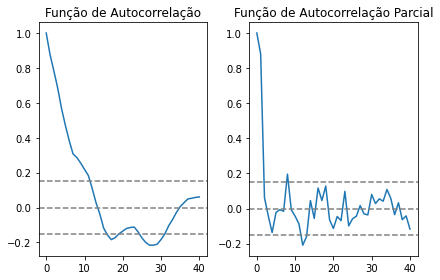

In [11]:
#  Para plotar ACF e PACF
# ACF: 

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Função de Autocorrelação')

#  PACF:

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray') 
plt.title('Função de Autocorrelação Parcial') 
plt.tight_layout()